In [24]:
import numpy as np
from patchify import patchify
from scipy.ndimage import rotate
from sklearn.model_selection import train_test_split

import pylab as plt
import matplotlib as mpl
from tqdm.notebook import tqdm

import tifffile as tiff

import os

import prepare_utils

In [2]:
%matplotlib notebook

In [3]:
def image_rotate(image, d_a):
    angles = np.arange(0, 350 + d_a, d_a)
    r_img_list = []
    for angle in angles:
        r_img = rotate(image, angle, mode='reflect', reshape=False, order=0)
        r_img_list.append(r_img)
    return r_img_list

In [20]:
def data_rotate(data, d_a):
    data_list = []
    for i in tqdm(range(data.shape[0])):
        data_j_list = []
        for j in range(data.shape[1]):
            data_j_list += image_rotate(data[i, j], d_a)
        data_list += data_j_list
    rotated_data = np.asarray(data_list)
    return rotated_data

In [ ]:
# def add_noise_to_data(data, seed, number_of_noise):
#     noise_data_list = []
#     for i in tqdm(range(number_of_noise)):
#         noise_data_list_i = []
#         for j in range(data.shape[0]):
#             noise = np.random.uniform(low=)
#             noise_data_list_i.append(data[i])

In [5]:
cmap = mpl.cm.get_cmap('gray_r', 5)

C:\Users\KamashevAM\AppData\Local\Temp\ipykernel_13208\1219812572.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('gray_r', 5)


In [6]:
dir_path = './label_data'

data_dir_path = os.path.join(dir_path, 'data')
filename = 'rec_00400.tif' 

label_dir_path = os.path.join(dir_path, 'label')

cluster_dir_path = os.path.join(dir_path, 'cluster')

In [7]:
data = tiff.imread(os.path.join(data_dir_path, filename))
label = tiff.imread(os.path.join(label_dir_path, filename))
cluster_label = tiff.imread(os.path.join(cluster_dir_path, filename))

In [8]:
data.shape,label.shape,cluster_label.shape,

((2615, 2615), (2615, 2615), (2615, 2615))

<IPython.core.display.Javascript object>


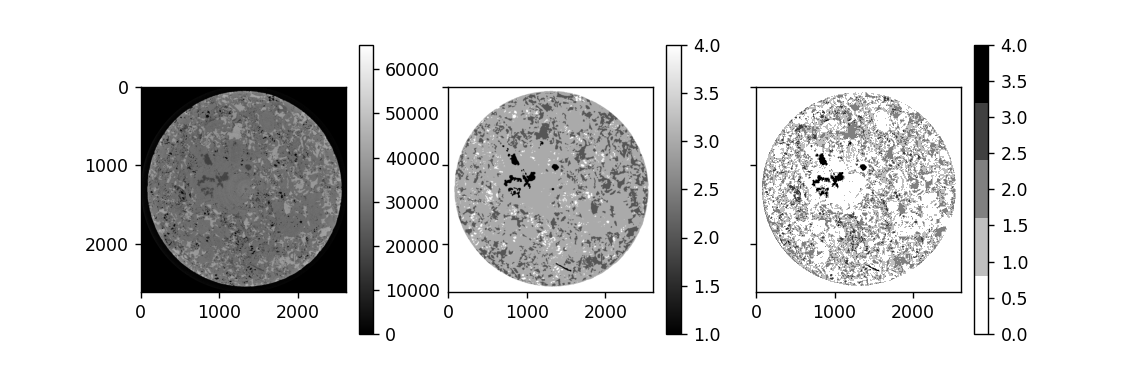

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(9, 3), sharex=True, sharey=True)

im = axs[0].imshow(data, aspect='equal', cmap='gray')
plt.colorbar(im, ax=axs[0])

im = axs[1].imshow(label, aspect='equal', cmap='gray')
plt.colorbar(im, ax=axs[1])

im = axs[2].imshow(cluster_label, aspect='equal', cmap=cmap)
plt.colorbar(im, ax=axs[2])


# Подготовка изображения

In [10]:
data_blur, sobelx, sobely = prepare_utils.calculate(data,
                                                    half_size=data.shape[0] // 2,
                                                    kernel_size=15,
                                                    radius=1230,
                                                    even_number=False)

In [11]:
data_blur.shape, sobelx.shape, sobely.shape

((2615, 2615), (2615, 2615), (2615, 2615))

In [12]:
np.nanmin(np.abs(data_blur))

1.0126108597680386e-08

# Нарезка изображения

In [25]:
data_cut_array = patchify(data_blur, (128, 128), step=128)
sobelx_cut_array = patchify(sobelx, (128, 128), step=128)
sobely_cut_array = patchify(sobely, (128, 128), step=128)

label_cut_array = patchify(label, (128, 128), step=128)

In [14]:
data_cut_array.shape

(20, 20, 128, 128)

In [26]:
rotated_cut_images = data_rotate(data_cut_array, d_a=10)
rotated_sobelx_images = data_rotate(sobelx_cut_array, d_a=10)
rotated_sobely_images = data_rotate(sobely_cut_array, d_a=10)

rotated_label_images = data_rotate(label_cut_array, d_a=10)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [28]:
X = np.stack((rotated_cut_images, rotated_sobelx_images, rotated_sobely_images), axis=3)

(14400, 128, 128, 3)

In [22]:
rotated_cut_images.shape

(14400, 128, 128)

In [29]:
5000/14400

0.3472222222222222

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, rotated_label_images, test_size=0.65, random_state=42)

In [34]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5040, 128, 128, 3), (9360, 128, 128, 3), (5040, 128, 128), (9360, 128, 128))

In [35]:
save_dir = 'train_data/without_noise'

In [36]:
np.save(os.path.join(save_dir, 'x_train.npy'), X_train)
np.save(os.path.join(save_dir, 'x_test.npy'), X_test)
np.save(os.path.join(save_dir, 'y_train.npy'), y_train)
np.save(os.path.join(save_dir, 'y_test.npy'), y_test)